# Goal
Purpose of this notebook is to get a feeling of the regression performance of pixel sums when using simple NNs.

In [2]:
import keras
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.keras.backend.set_floatx('float64') # increases accuracy

# Ideal regression
A network of one neuron fully connected to $n\times n$ pixels of an input image is easily capable to learn regression of the sum of all pixel values. This is accomplished when the bias is 0 and all weights are 1. The only error comes due to choice of datatype, if we increase from float32 (default) to float64 we get better accuracy. We can directly see this below:

32/32 [==============================] - 0s 648us/step
27.23093 27.23093241781294


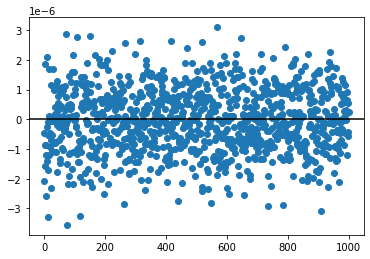

In [4]:
W = 7 # side length (width) of images
N = 1000 # no. samples
data = np.random.rand(N,W,W)
truth = np.sum(data, axis=(1,2)) # sum of all pixels in a image for all samples

model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)]) # a shallow model

model.get_weights()
model.set_weights([np.ones((W*W,1))])
pred = model.predict(data).flatten()
res = pred - truth
plt.plot(res, 'o');
plt.axhline(0, c='k');
print(pred[0], truth[0]) # error due to data type "rounding", i.e. cutoff

If we train a network, we would reach the state in which all weights are 1 eventually. However as we don't want to train infinitely we stick with rough convergence and a "good enough" error (std) of $\sigma_r=0.006$. Rescaling the std (by max-min) to our data we get a relative error of $\sim 0.006/13.6=0.04\%$.

32/32 [==============================] - 0s 766us/step
Standard deviation of residuals: 0.0062710518138397705


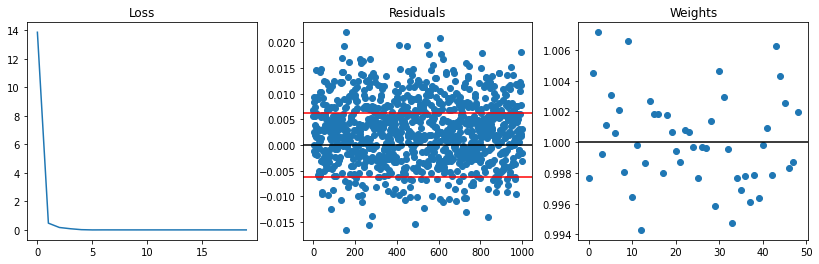

In [110]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

In [5]:
print(np.max(truth)-np.min(truth))

13.67253886355466


We see that the network correctly finds weights in the neighborhood of $1$.<br>

**Note:** Use MAE instead of MSE, as we want to train for pixel-perfect accuracy which is proportional to absolute error and not to its square. Train for very small `batch_sizes`, best even single-shot training.

# Noisy regression
Now, let's add some noise to each pixel value while regressing to the truth from above.

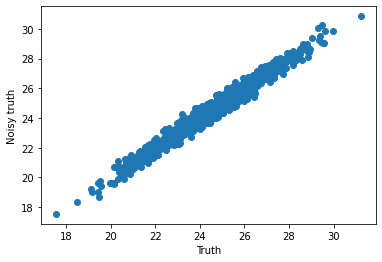

In [10]:
std = 0.05
noisy_data = data + np.random.normal(0,std,size=data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

In this case, let std of pixel value $i$ be $\sigma_i$ for $N=n\times n$ total pixel values in an image. Then the std of the sum of pixel values is $\sigma_{tot}=\sqrt{\sum_{i=1}^N{\sigma_i^2}}$. Thus for example for $\sigma=0.05, N=49$ we have $\sigma_{tot}=\sqrt{49\times 0.05^2}=0.35$, which is exactly the value that we get for std of residuals.

Let's do the same regression task as above but using the noisy data instead:

32/32 [==============================] - 0s 727us/step
Standard deviation of residuals: 0.33269240049243787


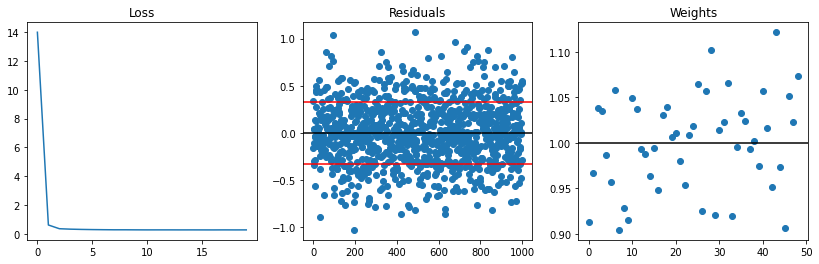

In [11]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

We see that the standard deviation of residuals is very close to $\sigma_{tot}$.

As expected, the predictions are more off. in this case we get a relative error of $\sim \{3.9, 7.8, 15.6, 31.3, ..., \gt 100\}\%$ for std=$\{0.025 0.05, 0.1, 0.2, ..., 1.0\}$, which scales linearly with the spread of the data (i.e. the std of noise). This makes sense, as there is no structure in the noise thus there is nothing to learn here for the network. A deeper network would thus also not be able to learn any more information - this is a hard limit.

# Regression of increasingly noisy data
Let's see how the network performs for data where the std of the noise scales with its pixel sum.

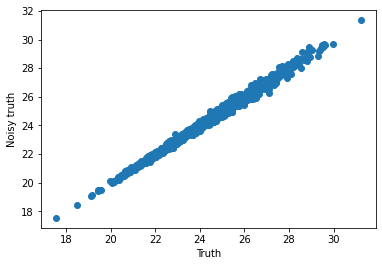

In [12]:
std = (truth-np.min(truth)) / (np.max(truth) - np.min(truth)) * 0.05
noisy_data = data + np.random.normal(0,std[:,None,None], data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

And again, train the model.

32/32 [==============================] - 0s 721us/step
Standard deviation of residuals: 0.16815644032658958


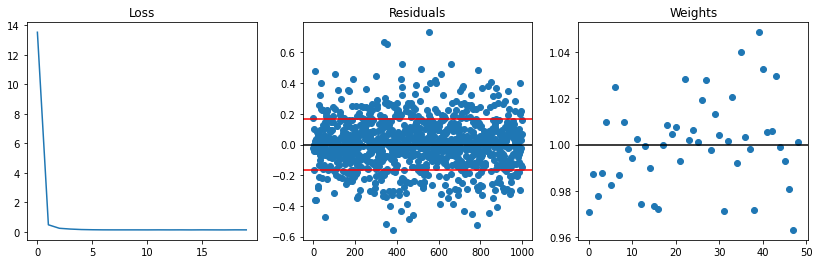

In [113]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mean_absolute_error', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=20, verbose=False, batch_size=1)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

The relative error about halves compared to the case where we applied noise equally to all images. The relative error here again scales linearly with the std of the noise we apply.

Let's also take a look how the std scales with pixel sums (truth):

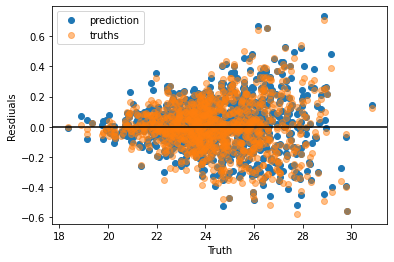

In [138]:
ids = truth.argsort()
sorted_res = pred[ids] - truth[ids]
plt.plot(truth[truth.argsort()], sorted_res, 'o', alpha=1, label='prediction');
plt.plot(truth[ids], noisy_truth[ids] - truth[ids], 'o', alpha=0.5, label='truths');

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Truth');
plt.legend();

Indeed this last plot shows a very good coincidence between the two residuals noisytruth-truth and predictions-truth. This confirms once again that our network cannot do better then the noise we impose, but it is capable of learning to exactly the regression of increasingly noisy data.

**Result**: For any shallow (or deep) network which maps an input image to a single (fully connected) output neuron we should (with enough training time) be able to learn a function which regresses the pixel sum up to the given std of noise in the data and which scales linearly with the given std. For increasingly noisy data the std of the residuals truth-prediction approximately halves in comparison to "peak" noise over the entire scale. **The main take-away is that the std of the residuals $\hat{y}-y$ and $\tilde{y}-y$ are approximately the same.** (where $y$ is the truth, $\hat{y}$ is the prediction and $\tilde{y}$ is data with (random) noise applied to it.)

# Mapping between representations
Here we are going to take a look at how a shallow network can learn a specific linear map and thereby allows to change representations in the same space ($d_i=d_o$ for $d_{i,o}$ being the dimensions of input and output space, respectively).

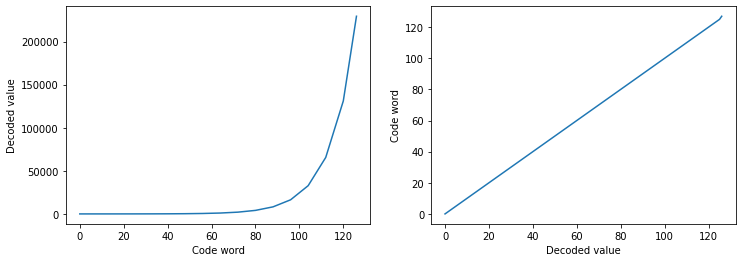

In [260]:
# Our function of interest is a bit-map to map values from the range 0...127 to another range.

from bitstring import BitArray
from functools import lru_cache

exp_bits = 4
man_bits = 3
max_TCval = (2**man_bits - 1) * 2**(2**exp_bits - 1)
max_TCcode = 2**(man_bits+exp_bits) - 1



@np.vectorize
@lru_cache(128)
def decode(code):
    code = int(code)
    assert(code.bit_length() <= man_bits+exp_bits)
    assert(code >= 0)
    
    bits = BitArray(uint=code, length=man_bits+exp_bits)
    ebits = bits[:exp_bits]
    mbits = bits[exp_bits:]
    
    if ebits.uint == 0:
        return mbits.uint
    else:
        return (BitArray('0b1') + mbits).uint << (ebits.uint - 1)
    
@np.vectorize
@lru_cache(128)
def encode(val):
    assert(val >= 0)
    val = np.int32(val)
    bit_len = val.item().bit_length()
    if bit_len <= man_bits:
        return val # special case: return mantissa if value in this range
    if val >= max_TCval:
        return max_TCcode # clip overflow
    
    exp = bit_len - man_bits
    man = val >> exp - 1
    
    ebits = BitArray(uint=exp, length=exp_bits)
    mbits = BitArray(uint=man, length=man.item().bit_length())[1:]
    
    return (ebits+mbits).uint

r = np.array(range(max_TCcode))

fig,ax = plt.subplots(1, 2, figsize=(12,4))

decoded_r = decode(r)
ax[0].plot(decoded_r)
ax[0].set_xlabel('Code word')
ax[0].set_ylabel('Decoded value');

ax[1].plot(encode(decoded_r));
ax[1].set_xlabel('Decoded value')
ax[1].set_ylabel('Code word');

We see the map is invertible, i.e. bijective. Thus, in principle we should be able to find such a map. Though the map is **not** linear. We need to use some non-linearity in our network and some more depth.

First, let's create some data. Here are some random integers between 0 and the maximum allowed encoded pixel (TC) value.

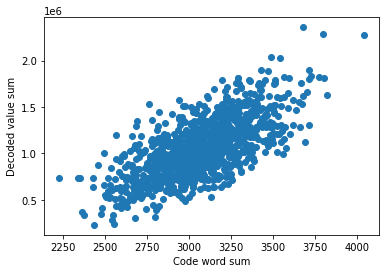

In [238]:
# Let's see how increasingly noisy data is decoded.
W = 7 # side length (width) of images
N = 1000 # no. samples
encoded_data = np.random.randint(0, max_TCcode, size=(N,W,W))
encoded_truth = np.sum(encoded_data, axis=(1,2))
decoded_data = decode(encoded_data)
decoded_truth = np.sum(decoded_data, axis=(1,2))
plt.plot(encoded_truth, decoded_truth, 'o')
plt.xlabel('Code word sum');
plt.ylabel('Decoded value sum');

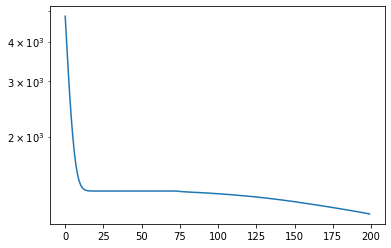

In [118]:
# Let's train a model to encode the data
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='sigmoid'),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(49, activation='linear'),
                          keras.layers.Reshape((7,7))
                         ])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(decoded_data, encoded_data, epochs=200, verbose=False, batch_size=8)
plt.plot(hist.history['loss'])
plt.yscale('log')

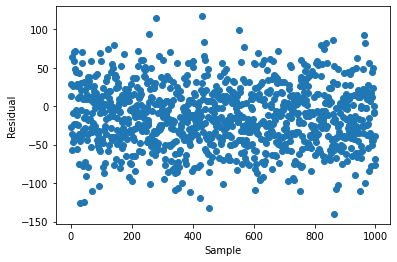

In [122]:
pred = model.predict(decoded_data)
pred_encoded_truth = np.sum(pred, axis=(1,2))
res = pred_encoded_truth - encoded_truth
plt.plot(res, 'o')
plt.xlabel('Sample');
plt.ylabel('Residual');

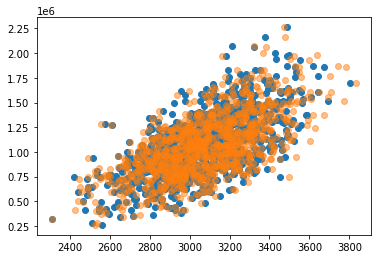

In [120]:
plt.plot(pred_encoded_truth,decoded_truth,'o')
plt.plot(encoded_truth, decoded_truth, 'o', alpha=0.5);
plt.xlabel('Code word sum');
plt.ylabel('Decoded value sum');

We see generally good agreement between the analytical results and the predictions. We also notice that the training did not saturate yet and the increased network capacity needed to fit the function. These observations can give us a bit of confidence that the network is capable of eventually finding the correct map in the limit of infinite training time.

# Concatenate networks
Now we take a look at combined encoding and regression of **increasingly noisy** data.

We want to achieve a distribution like this, on the left is our **decoded noisy** truth and on the right our **encoded noisy** truth both as a function of the **decoded perfect** truth.

<table>
    <tr>
        <td><img src="mod2.png" width="400"></td>
        <td><img src="mod1.png" width="400"></td>
    </tr>
</table>

This data exhibits two properties we must keep in mind while recreating it:
1. From the left plot we see that the pixel sum of **decoded values (truth)** becomes **increasingly noisy**.
2. From the right we see that the distribution of **encoded pixel values (codes)** is highly non-uniform. Most of the pixels have very small values while other few have relatively large values. Only this pixel distribution can cause such large fluctuations for similar truth values due to the property of the decoding algorithm to leave largly scale only high values. Thus, small differences in pixel distributions (which sum to the same pixel sum) can cause large fluctuations in pixel sums after we **decode the codes**.

Let's try a Beta-distribution with $a,b \lt 1$ to create the **encoded** pixel distributions.

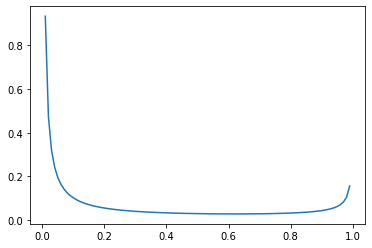

In [484]:
from scipy.stats import beta

x = np.linspace(0,1,100)
a,b = 0.01,0.4
rv = beta(a,b)

plt.plot(x, rv.pdf(x));

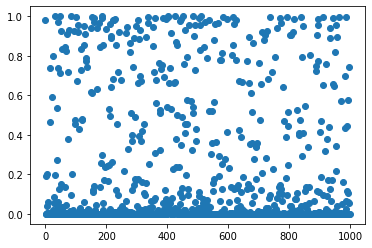

In [423]:
dist = np.random.beta(0.1,0.4,size=1000)
plt.plot(dist, 'o');

That's looking about right. Let's generate some data as before.

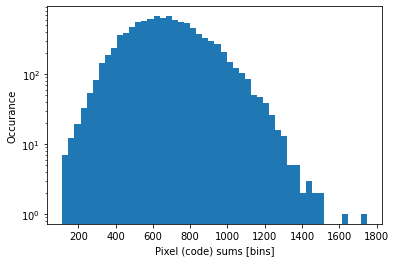

In [838]:
W = 7 # side length (width) of images
N = 10000 # no. samples
a,b = 0.1, 0.8

data = np.random.beta(a,b,size=(N,W,W))
codes = (data * 127).astype(int)
truth = decode(codes)

plt.hist(np.sum(codes, axis=(1,2)),bins=50)
plt.xlabel('Pixel (code) sums [bins]')
plt.ylabel('Occurance');
plt.yscale('log');

This distribution looks a bit different from the reference distribution. However, in the following we see that it produces about the same plots.<br>
<img src="mod3.png" width="400">

If we decode those codes and plot them vs the encoded truth we get:

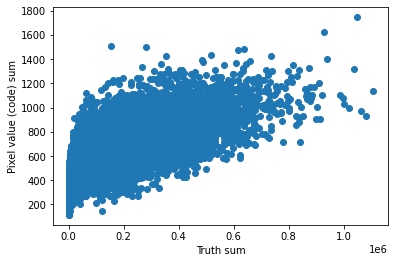

In [839]:
code_sum = np.sum(codes, axis=(1,2))
truth_sum = np.sum(truth, axis=(1,2))

plt.plot(truth_sum, code_sum, 'o');
plt.xlabel('Truth sum');
plt.ylabel('Pixel value (code) sum');

This looks at least similar. Now, we need to add some noise. **Note:** The x-axis has a different scale than the reference as we don't convert to MeV.

Let's make some noise. For this we add a random normal value to each pixel value which is proportional to its magnitude and then renormalize and convert to integer code.

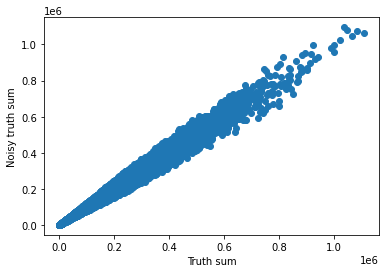

In [840]:
noisy_truth = truth + np.random.uniform(-truth/4, truth/4)
noisy_truth_sum = np.sum(noisy_truth, axis=(1,2))

plt.plot(truth_sum, noisy_truth_sum, 'o');
plt.xlabel('Truth sum');
plt.ylabel('Noisy truth sum');

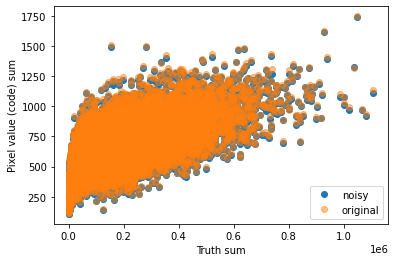

In [841]:
noisy_codes = encode(noisy_truth)
noisy_code_sum = np.sum(noisy_codes, axis=(1,2))
plt.plot(truth_sum, noisy_code_sum, 'o', label='noisy');
plt.plot(truth_sum, code_sum, 'o', alpha=0.5, label='original');

plt.xlabel('Truth sum');
plt.ylabel('Pixel value (code) sum');
plt.legend(loc='lower right');

Now, that we have generated the data, in the next step we train a network to convert **noisy codes** to **noisy truth**. In step 2 we then train another network to predict **perfect truth sum** from **noisy truth**. Afterwards, we can concatenate these two networks to accomplish the prediction (regression) of **perfect truth sums** from **noisy codes**. Note that we could also train the first network to predict **perfect truth** instead of noisy ones. We keep this option open until last where we build a unified network to train one large network to do both tasks together. And compare its performance to the concatenated network.

**Step 1:** Noisy truth from noisy codes.<br> 

**Note:** For training we need to rescale the truth, otherwise the network can't learn. We simply min-max scale the predictions of the network by this same factor.

In [847]:
truth_range = np.max(truth) - np.min(truth)
code_range = np.max(codes) - np.min(codes)

noisy_truth_range = np.max(noisy_truth) - np.min(noisy_truth)
noisy_code_range = np.max(noisy_codes) - np.min(noisy_codes)

normed_truth = truth / truth_range
normed_truth_sum = np.sum(normed_truth, axis=(1,2))

noisy_normed_truth = noisy_truth / noisy_truth_range
noisy_normed_codes = noisy_codes / noisy_code_range

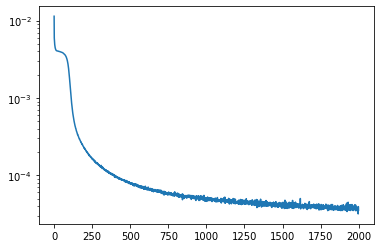

In [843]:
decoder = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(49, activation='linear'),
                          keras.layers.Reshape((W,W))
                         ])

decoder.compile(loss='mse', optimizer='adam')
hist = decoder.fit(noisy_normed_codes, noisy_normed_truth, epochs=2000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

We probably could have trained longer, however this should be done on a more powerful computer. (I am using my CPU only for training). We see that for large epochs the loss starts fluctuating more. Maybe a learning rate scheduler can help here.

313/313 [==============================] - 0s 939us/step
rel std error:  0.04188388350542968


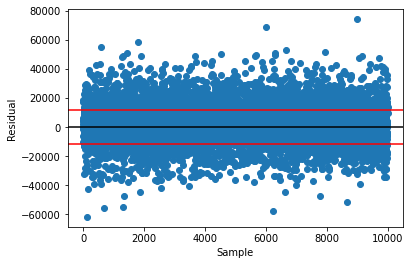

In [844]:
pred = decoder.predict(noisy_normed_codes) * noisy_truth_range
pred_sum = np.sum(pred, axis=(1,2))
res = pred_sum - noisy_truth_sum

std = np.std(res)
print('rel std error: ', std/noisy_truth_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

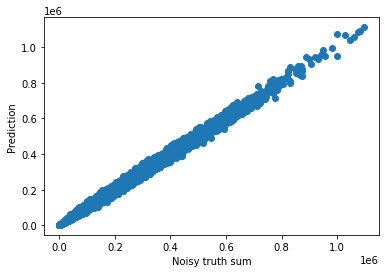

In [845]:
plt.plot(noisy_truth_sum, pred_sum,'o');
plt.xlabel('Noisy truth sum');
plt.ylabel('Prediction');

Now, let's train our regression network

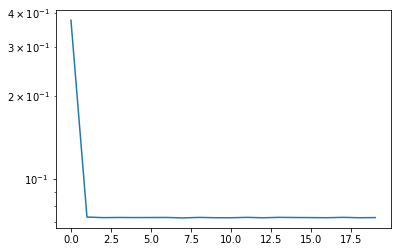

In [848]:
regressor = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

regressor.compile(loss='mean_absolute_error', optimizer='adam')

hist = regressor.fit(noisy_normed_truth, normed_truth_sum, epochs=20, verbose=False, batch_size=1)
plt.plot(hist.history['loss']);
plt.yscale('log');

313/313 [==============================] - 0s 533us/step
rel. std error:  0.10379212524555802


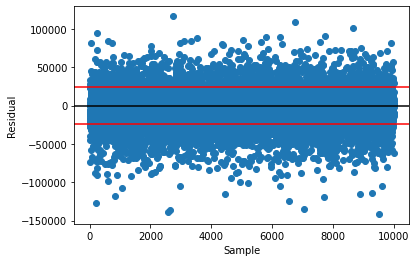

In [850]:
pred = regressor.predict(noisy_normed_truth) * truth_range
res = pred.flatten() - truth_sum
std = np.std(res)

print('rel. std error: ', std/truth_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

Now, concatenate the networks

313/313 [==============================] - 0s 692us/step
rel std error:  0.11618498048375306


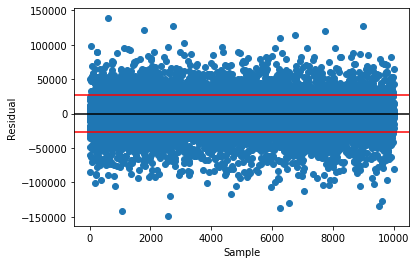

In [851]:
model = keras.Sequential([decoder, regressor])
pred = model.predict(noisy_normed_codes) * truth_range

res = pred.flatten() - truth_sum
std = np.std(res)

print('rel std error: ', std/truth_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

Next, let's do both tasks together in a single network:

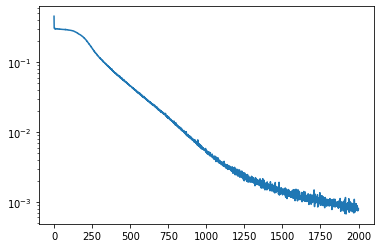

In [852]:
model2 = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(32, activation='sigmoid'),
                          keras.layers.Dense(1, activation='linear'),
                         ])

model2.compile(loss='mse', optimizer='adam')
hist = model2.fit(noisy_normed_codes, normed_truth_sum, epochs=2000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

313/313 [==============================] - 0s 663us/step
rel. error 0.02734083764997885


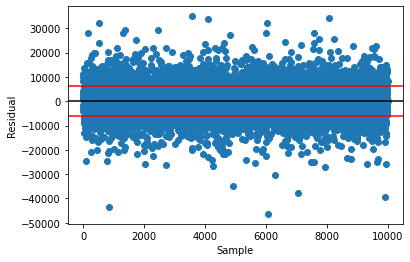

In [854]:
pred = model2.predict(noisy_normed_codes) * truth_range

res = pred.flatten() - truth_sum
std = np.std(res)

print('rel. error', std / truth_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

As expected, the combined training performs much better and needs less training. In this case the network is allowed to directly predict from noisy data and doesn't need to first decode it (to noisy truth) and then regress the sums from there. This combined way of training should thus be the preferred mode, i.e. don't hard-code a "path" that the network has to take - let it find its own way. 

# Conclusions
* Pixel sum regression is an easy task which can be learned perfectly (up to given neuron accuracy, i.e. data type accuracy) in a *shallow* network in a short time
* If we add (random) noise to data the predictions of a regression network shows same amount of noise.
* With enough time and training data a network can learn (arbitrary, nonlinear) bijective maps between representations of data.
* Thus, combining the three results from above we showed that we can regress true underlying pixel sums from noisy representations of data upto an accuracy which corresponds to the noise in the representation of interest wrt. to true pixel sums.
* Lastly, we can see that a network which is trained on the first three points together performs much better after the same amount of training. One reason for this could be that it finds direct correlations between the (noisy) input data and the true underlying pixel sum which would simply be lost if we choose the concatenation strategy.